<a href="https://colab.research.google.com/github/denisecammarota/d2ai-notes/blob/main/ch9_d2ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn.utils as utils

In [ ]:
import os
import hashlib
import urllib.request

In [ ]:
import collections

In [ ]:
import re

In [ ]:
import os, hashlib, urllib.request, zipfile

# Processing text data

In [ ]:
DATA_URL = "https://d2l-data.s3-accelerate.amazonaws.com/"
FILENAME = "timemachine.txt"
SHA1 = "090b5e7e70c295757f55df93cb0a180b9691891a"

def download(url, root="data", filename=FILENAME, sha1_hash=None):
    os.makedirs(root, exist_ok=True)
    path = os.path.join(root, filename)

    if os.path.exists(path):
        if sha1_hash:
            sha1 = hashlib.sha1(open(path, "rb").read()).hexdigest()
            if sha1 == sha1_hash:
                return path
        else:
            return path

    print("Downloading...")
    urllib.request.urlretrieve(url + filename, path)

    if sha1_hash:
        sha1 = hashlib.sha1(open(path, "rb").read()).hexdigest()
        assert sha1 == sha1_hash, "SHA-1 mismatch!"

    return path

fname = download(DATA_URL, sha1_hash=SHA1)

with open(fname, "r", encoding="utf-8") as f:
    raw_text = f.read()

raw_text[:60]

Downloading...


'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [ ]:
def preprocess(text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

In [ ]:
text = preprocess(raw_text)

In [ ]:
def tokenize(text):
    return list(text)

In [ ]:
tokens = tokenize(text)

In [ ]:
class Vocab:

  def __init__(self, tokens = [], min_freq = 0, reserved_tokens = []):
    # Flatten a 2d list if needed with a lambda function
    if tokens and isinstance(tokens[0], list):
      tokens = [token for line in tokens for token in line]
    # Count token frequencies using the collections package from base Python
    counter = collections.Counter(tokens)
    self.token_freqs = sorted(counter.items(), key = lambda x: x[1], reverse = True)
    # The list of unique tokens - constructing dictionaries
    self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

  def __len__(self):
    return len(self.idx_to_token)

  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if hasattr(indices, '__len__') and len(indices) > 1:
      return [self.idx_to_token[int(index)] for index in indices]
    return self.idx_to_token[indices]

  @property
  def unk(self):
    return self.token_to_idx['<unk>']

In [ ]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]

In [ ]:
class TimeMachine():

  def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000, root = 'data'):
    #super(self).__init__()
    #self.save_hyperparameters()
    self.batch_size = batch_size
    self.num_steps = num_steps
    self.num_train = num_train
    self.num_val = num_val
    self.root = root

    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1]
                          for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

  def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    dataset = TensorDataset(self.X[idx], self.Y[idx])
    return DataLoader(dataset,
                      batch_size = self.batch_size,
                      shuffle = train)

  def _download(self):
        return open(download(DATA_URL, root=self.root, sha1_hash=SHA1), encoding="utf-8").read()

  def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

  def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

  def _tokenize(self, text):
    return list(text)

In [ ]:
data = TimeMachine(batch_size=1024, num_steps=32)

In [ ]:
train_loader = data.get_dataloader(train = True)
test_loader = data.get_dataloader(train = False)

# LSTMs

In [ ]:
class LSTMML(nn.Module):

    def __init__(self, vocab_size, num_hiddens, sigma=0.01):

        super().__init__()
        self.vocab_size = vocab_size # size of the corpus
        self.num_hiddens = num_hiddens # hidden state size

        self.rnn = nn.LSTM(vocab_size, num_hiddens) # the lstm itself
        self.output = nn.Linear(num_hiddens, vocab_size)

        nn.init.normal_(self.output.weight, std = sigma)
        nn.init.zeros_(self.output.bias)

    def one_hot(self, X):
        return F.one_hot(X.T.long(), self.vocab_size).float()

    def predict(self, prefix, num_preds, vocab, device):
        self.to(device)
        self.eval()

        outputs = [vocab[prefix[0]]]

        get_input = lambda: torch.tensor([outputs[-1]], device = device).reshape(1, 1)

        state = None

        for char in prefix[1:]:
          _, state = self(get_input(), state)
          outputs.append(vocab[char])

        for _ in range(num_preds):
          y, state = self(get_input(), state)
          next_id = int(y.argmax(dim = 2).reshape(1))
          outputs.append(next_id)

        return ''.join([vocab.idx_to_token[i] for i in outputs])

    def forward(self, X, state=None):

        # do one hot encoding
        embs = self.one_hot(X)

        # initialize state if it is beginning of a sequence
        # shape = (num_layers, batch_size, num_hiddens)
        if state is None:
            h_0 = torch.zeros(
                (1, X.shape[0], self.num_hiddens),
                device = X.device)
            c_0 = torch.zeros((1, X.shape[0], self.num_hiddens),
                              device = X.device)
            state = (h_0, c_0)

        # forward pass through RNN
        # outputs shape: (steps, batch, hidden)
        # state: (h_n, c_n)
        outputs, state = self.rnn(embs, state)

        # project output to vocabulary size
        # from (steps*batch, hidden) ----> (steps*batch, vocab)
        reshaped_outputs = outputs.view(-1, outputs.shape[-1])
        y = self.output(reshaped_outputs)

        # reshape back to (step, batch, vocab)
        return y.view(outputs.shape[0], outputs.shape[1], -1), state





In [ ]:
model = LSTMML(vocab_size = len(data.vocab), num_hiddens = 64).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() # includes softmax classifier
optimizer = optim.Adam(model.parameters(), lr = 0.5)
n_epochs = 100
train_loss = []
test_loss = []
test_accuracy = []
device = 'cpu'

for epoch in range(n_epochs):
  model.train()
  train_aux = 0
  train_items = 0
  state = None

  for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

    if state is not None:
      if state[0].shape[1] != batch_X.shape[0]:
        state = None

    optimizer.zero_grad()

    # forward pass (output, shape)
    # output shape: (steps, batch, vocab)
    # state shape:(h, c)
    output, state = model(batch_X, state)

    # reshape for crossentropyloss
    # expects (N, C) where N = batch*steps, C = vocabulary size
    output_flattened = output.view(-1, model.vocab_size)
    targets_flattened = batch_y.T.reshape(-1).long()
    loss = criterion(output_flattened, targets_flattened)

    # backward pass
    loss.backward()

    # gradient clipping
    #utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()

    state = (state[0].detach(), state[1].detach())

    train_aux += loss.item() * batch_X.size(0)
    train_items += batch_X.shape[0]

  train_loss.append(train_aux/train_items)

  model.eval()
  test_aux = 0
  test_items = 0
  total_correct = 0
  total_tokens = 0

  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      output, _ = model(batch_X)

      output_flattened = output.view(-1, model.vocab_size)
      targets_flattened = batch_y.T.reshape(-1).long()

      loss = criterion(output_flattened, targets_flattened)

      predicted_labels = output_flattened.argmax(dim = 1)
      total_correct += (predicted_labels == targets_flattened).sum().item()
      total_tokens += targets_flattened.numel()

      test_aux += loss.item() * batch_X.shape[0]
      test_items += batch_X.shape[0]

  test_accuracy.append(total_correct / total_tokens)
  test_loss.append(test_aux / test_items)

  if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}")


Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45
Epoch 50
Epoch 55
Epoch 60
Epoch 65
Epoch 70
Epoch 75
Epoch 80
Epoch 85
Epoch 90
Epoch 95
Epoch 100


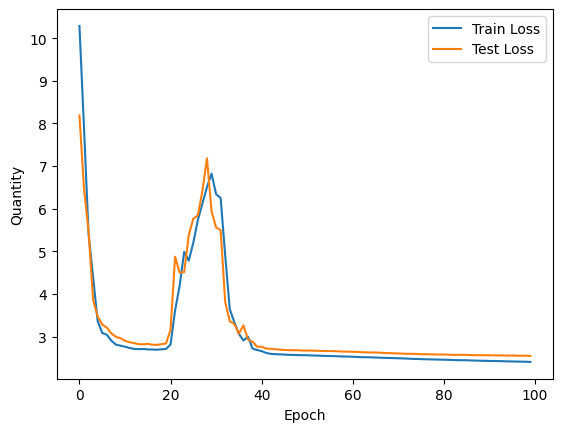

In [ ]:
plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss, label = 'Test Loss')
#plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Quantity')
plt.show()

In [ ]:
model.to(device)

LSTMML(
  (rnn): LSTM(28, 64)
  (output): Linear(in_features=64, out_features=28, bias=True)
)

In [ ]:
generated_text = model.predict('it has', 20, data.vocab, device)

In [ ]:
generated_text

'it hase t the the the the '

# GRUs

In [ ]:
class GRUML(nn.Module):

    def __init__(self, vocab_size, num_hiddens, sigma=0.01):

        super().__init__()
        self.vocab_size = vocab_size # size of the corpus
        self.num_hiddens = num_hiddens # hidden state size

        self.rnn = nn.GRU(vocab_size, num_hiddens) # the gru itself
        self.output = nn.Linear(num_hiddens, vocab_size)

        nn.init.normal_(self.output.weight, std = sigma)
        nn.init.zeros_(self.output.bias)

    def one_hot(self, X):
        return F.one_hot(X.T.long(), self.vocab_size).float()

    def predict(self, prefix, num_preds, vocab, device):
        self.to(device)
        self.eval()

        outputs = [vocab[prefix[0]]]

        get_input = lambda: torch.tensor([outputs[-1]], device = device).reshape(1, 1)

        state = None

        for char in prefix[1:]:
          _, state = self(get_input(), state)
          outputs.append(vocab[char])

        for _ in range(num_preds):
          y, state = self(get_input(), state)
          next_id = int(y.argmax(dim = 2).reshape(1))
          outputs.append(next_id)

        return ''.join([vocab.idx_to_token[i] for i in outputs])

    def forward(self, X, state=None):

        # do one hot encoding
        embs = self.one_hot(X)

        # initialize state if it is beginning of a sequence
        # shape = (num_layers, batch_size, num_hiddens)
        if state is None:
            state = torch.zeros(
                (1, X.shape[0], self.num_hiddens),
                device = X.device)

        # forward pass through RNN
        # outputs shape: (steps, batch, hidden)
        # state: (h_n, c_n)
        outputs, state = self.rnn(embs, state)

        # project output to vocabulary size
        # from (steps*batch, hidden) ----> (steps*batch, vocab)
        reshaped_outputs = outputs.view(-1, outputs.shape[-1])
        y = self.output(reshaped_outputs)

        # reshape back to (step, batch, vocab)
        return y.view(outputs.shape[0], outputs.shape[1], -1), state

In [ ]:
model = GRUML(vocab_size = len(data.vocab), num_hiddens = 32).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() # includes softmax classifier
optimizer = optim.Adam(model.parameters(), lr = 0.1)
n_epochs = 100
train_loss = []
test_loss = []
test_accuracy = []
device = 'cpu'

for epoch in range(n_epochs):
  model.train()
  train_aux = 0
  train_items = 0
  state = None

  for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

    if state is not None:
      if state[0].shape[1] != batch_X.shape[0]:
        state = None

    optimizer.zero_grad()

    # forward pass (output, shape)
    # output shape: (steps, batch, vocab)
    # state shape:(h, c)
    output, state = model(batch_X, state)

    # reshape for crossentropyloss
    # expects (N, C) where N = batch*steps, C = vocabulary size
    output_flattened = output.view(-1, model.vocab_size)
    targets_flattened = batch_y.T.reshape(-1).long()
    loss = criterion(output_flattened, targets_flattened)

    # backward pass
    loss.backward()

    # gradient clipping
    #utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()

    state = state.detach()

    train_aux += loss.item() * batch_X.size(0)
    train_items += batch_X.shape[0]

  train_loss.append(train_aux/train_items)

  model.eval()
  test_aux = 0
  test_items = 0
  total_correct = 0
  total_tokens = 0

  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      output, _ = model(batch_X)

      output_flattened = output.view(-1, model.vocab_size)
      targets_flattened = batch_y.T.reshape(-1).long()

      loss = criterion(output_flattened, targets_flattened)

      predicted_labels = output_flattened.argmax(dim = 1)
      total_correct += (predicted_labels == targets_flattened).sum().item()
      total_tokens += targets_flattened.numel()

      test_aux += loss.item() * batch_X.shape[0]
      test_items += batch_X.shape[0]

  test_accuracy.append(total_correct / total_tokens)
  test_loss.append(test_aux / test_items)

  if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}")

Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45
Epoch 50
Epoch 55
Epoch 60
Epoch 65
Epoch 70
Epoch 75
Epoch 80
Epoch 85
Epoch 90
Epoch 95
Epoch 100


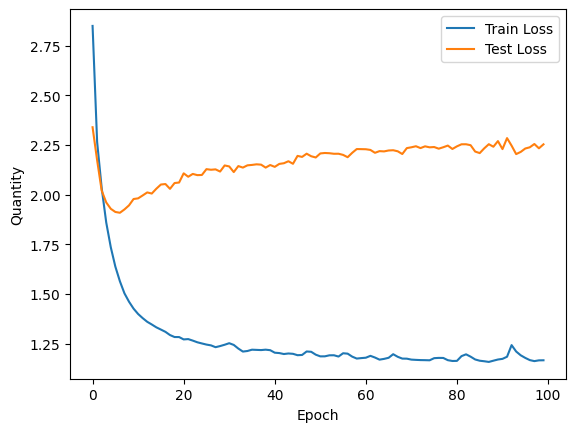

In [ ]:
plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss, label = 'Test Loss')
#plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Quantity')
plt.show()

In [ ]:
model.to(device)

GRUML(
  (rnn): GRU(28, 32)
  (output): Linear(in_features=32, out_features=28, bias=True)
)

In [ ]:
generated_text = model.predict('it has', 20, data.vocab, device)

In [ ]:
generated_text

'it has i was so it said th'

# Deep Recurrent Neural Networks with GRU

In [ ]:
class DeepGRU(nn.Module):

    def __init__(self, vocab_size, num_hiddens, num_layers = 1, dropout = 0, sigma=0.01):

        super().__init__()
        self.vocab_size = vocab_size # size of the corpus
        self.num_hiddens = num_hiddens # hidden state size
        self.num_layers = num_layers

        self.rnn = nn.GRU(vocab_size, num_hiddens, num_layers, dropout = dropout) # the gru itself
        self.output = nn.Linear(num_hiddens, vocab_size)

        nn.init.normal_(self.output.weight, std = sigma)
        nn.init.zeros_(self.output.bias)

    def one_hot(self, X):
        return F.one_hot(X.T.long(), self.vocab_size).float()

    def predict(self, prefix, num_preds, vocab, device):
        self.to(device)
        self.eval()

        outputs = [vocab[prefix[0]]]

        get_input = lambda: torch.tensor([outputs[-1]], device = device).reshape(1, 1)

        state = None

        for char in prefix[1:]:
          _, state = self(get_input(), state)
          outputs.append(vocab[char])

        for _ in range(num_preds):
          y, state = self(get_input(), state)
          next_id = int(y.argmax(dim = 2).reshape(1))
          outputs.append(next_id)

        return ''.join([vocab.idx_to_token[i] for i in outputs])

    def forward(self, X, state=None):

        # do one hot encoding
        embs = self.one_hot(X)

        # initialize state if it is beginning of a sequence
        # shape = (num_layers, batch_size, num_hiddens)
        if state is None:
            state = torch.zeros(
                (self.num_layers, X.shape[0], self.num_hiddens),
                device = X.device)

        # forward pass through RNN
        # outputs shape: (steps, batch, hidden)
        # state: (h_n, c_n)
        outputs, state = self.rnn(embs, state)

        # project output to vocabulary size
        # from (steps*batch, hidden) ----> (steps*batch, vocab)
        reshaped_outputs = outputs.view(-1, outputs.shape[-1])
        y = self.output(reshaped_outputs)

        # reshape back to (step, batch, vocab)
        return y.view(outputs.shape[0], outputs.shape[1], -1), state

In [ ]:
model = DeepGRU(vocab_size = len(data.vocab), num_hiddens = 32, num_layers = 2).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() # includes softmax classifier
optimizer = optim.Adam(model.parameters(), lr = 0.5)
n_epochs = 100
train_loss = []
test_loss = []
test_accuracy = []
device = 'cpu'

for epoch in range(n_epochs):
  model.train()
  train_aux = 0
  train_items = 0
  state = None

  for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

    if state is not None:
      if state[0].shape[1] != batch_X.shape[0]:
        state = None

    optimizer.zero_grad()

    # forward pass (output, shape)
    # output shape: (steps, batch, vocab)
    # state shape:(h, c)
    output, state = model(batch_X, state)

    # reshape for crossentropyloss
    # expects (N, C) where N = batch*steps, C = vocabulary size
    output_flattened = output.view(-1, model.vocab_size)
    targets_flattened = batch_y.T.reshape(-1).long()
    loss = criterion(output_flattened, targets_flattened)

    # backward pass
    loss.backward()

    # gradient clipping
    #utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()

    state = state.detach()

    train_aux += loss.item() * batch_X.size(0)
    train_items += batch_X.shape[0]

  train_loss.append(train_aux/train_items)

  model.eval()
  test_aux = 0
  test_items = 0
  total_correct = 0
  total_tokens = 0

  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      output, _ = model(batch_X)

      output_flattened = output.view(-1, model.vocab_size)
      targets_flattened = batch_y.T.reshape(-1).long()

      loss = criterion(output_flattened, targets_flattened)

      predicted_labels = output_flattened.argmax(dim = 1)
      total_correct += (predicted_labels == targets_flattened).sum().item()
      total_tokens += targets_flattened.numel()

      test_aux += loss.item() * batch_X.shape[0]
      test_items += batch_X.shape[0]

  test_accuracy.append(total_correct / total_tokens)
  test_loss.append(test_aux / test_items)

  if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}")

Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45
Epoch 50
Epoch 55
Epoch 60
Epoch 65
Epoch 70
Epoch 75
Epoch 80
Epoch 85
Epoch 90
Epoch 95
Epoch 100


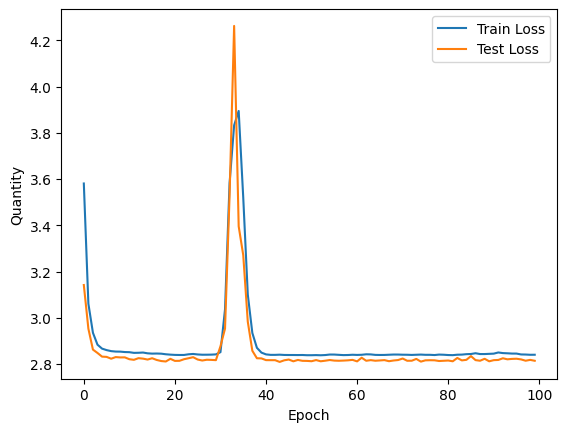

In [ ]:
plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss, label = 'Test Loss')
#plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Quantity')
plt.show()

In [ ]:
model.to(device)

DeepGRU(
  (rnn): GRU(28, 32, num_layers=2)
  (output): Linear(in_features=32, out_features=28, bias=True)
)

In [ ]:
generated_text = model.predict('it has', 20, data.vocab, device)

In [ ]:
generated_text

'it has                    '

# Bidirectional RNNs with GRU

In [ ]:
class BiGRU(nn.Module):

    def __init__(self, vocab_size, num_hiddens, sigma=0.01):

        super().__init__()
        self.vocab_size = vocab_size # size of the corpus
        self.num_hiddens = num_hiddens # hidden state size

        self.rnn = nn.GRU(vocab_size, num_hiddens, bidirectional = True) # the gru itself
        self.output = nn.Linear(num_hiddens*2, vocab_size)

        nn.init.normal_(self.output.weight, std = sigma)
        nn.init.zeros_(self.output.bias)

    def one_hot(self, X):
        return F.one_hot(X.T.long(), self.vocab_size).float()

    def forward(self, X, state=None):

        # do one hot encoding
        embs = self.one_hot(X)

        # initialize state if it is beginning of a sequence
        # shape = (num_layers, batch_size, num_hiddens)
        if state is None:
            state = torch.zeros(
                (2, X.shape[0], self.num_hiddens),
                device = X.device)

        # forward pass through RNN
        # outputs shape: (steps, batch, hidden)
        # state: (h_n, c_n)
        outputs, state = self.rnn(embs, state)

        # project output to vocabulary size
        # from (steps*batch, hidden) ----> (steps*batch, vocab)
        reshaped_outputs = outputs.view(-1, outputs.shape[-1])
        y = self.output(reshaped_outputs)

        # reshape back to (step, batch, vocab)
        return y.view(outputs.shape[0], outputs.shape[1], -1), state

In [ ]:
model = BiGRU(vocab_size = len(data.vocab), num_hiddens = 32).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() # includes softmax classifier
optimizer = optim.Adam(model.parameters(), lr = 0.5)
n_epochs = 100
train_loss = []
test_loss = []
test_accuracy = []
device = 'cpu'

for epoch in range(n_epochs):
  model.train()
  train_aux = 0
  train_items = 0
  state = None

  for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

    if state is not None:
      if state[0].shape[1] != batch_X.shape[0]:
        state = None

    optimizer.zero_grad()

    # forward pass (output, shape)
    # output shape: (steps, batch, vocab)
    # state shape:(h, c)
    output, state = model(batch_X, state)

    # reshape for crossentropyloss
    # expects (N, C) where N = batch*steps, C = vocabulary size
    output_flattened = output.view(-1, model.vocab_size)
    targets_flattened = batch_y.T.reshape(-1).long()
    loss = criterion(output_flattened, targets_flattened)

    # backward pass
    loss.backward()

    # gradient clipping
    #utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()

    state = state.detach()

    train_aux += loss.item() * batch_X.size(0)
    train_items += batch_X.shape[0]

  train_loss.append(train_aux/train_items)

  model.eval()
  test_aux = 0
  test_items = 0
  total_correct = 0
  total_tokens = 0

  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      output, _ = model(batch_X)

      output_flattened = output.view(-1, model.vocab_size)
      targets_flattened = batch_y.T.reshape(-1).long()

      loss = criterion(output_flattened, targets_flattened)

      predicted_labels = output_flattened.argmax(dim = 1)
      total_correct += (predicted_labels == targets_flattened).sum().item()
      total_tokens += targets_flattened.numel()

      test_aux += loss.item() * batch_X.shape[0]
      test_items += batch_X.shape[0]

  test_accuracy.append(total_correct / total_tokens)
  test_loss.append(test_aux / test_items)

  if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}")

Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45
Epoch 50
Epoch 55
Epoch 60
Epoch 65
Epoch 70
Epoch 75
Epoch 80
Epoch 85
Epoch 90
Epoch 95
Epoch 100


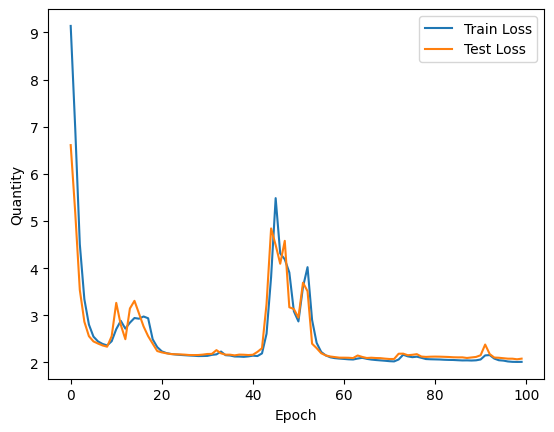

In [ ]:
plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss, label = 'Test Loss')
#plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Quantity')
plt.show()

# Downloading and processing datset

In [ ]:
class Vocab:

  def __init__(self, tokens = [], min_freq = 0, reserved_tokens = []):
    # Flatten a 2d list if needed with a lambda function
    if tokens and isinstance(tokens[0], list):
      tokens = [token for line in tokens for token in line]
    # Count token frequencies using the collections package from base Python
    counter = collections.Counter(tokens)
    self.token_freqs = sorted(counter.items(), key = lambda x: x[1], reverse = True)
    # The list of unique tokens - constructing dictionaries
    self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

  def __len__(self):
    return len(self.idx_to_token)

  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if hasattr(indices, '__len__') and len(indices) > 1:
      return [self.idx_to_token[int(index)] for index in indices]
    return self.idx_to_token[indices]

  @property
  def unk(self):
    return self.token_to_idx['<unk>']

In [ ]:
DATA_URL = "https://d2l-data.s3-accelerate.amazonaws.com/"
FILENAME = "fra-eng.zip"
SHA1 = "94646ad1522d915e7b0f9296181140edcf86a4f5"

def download(url, root="data", filename=FILENAME, sha1_hash=None):
    os.makedirs(root, exist_ok=True)
    path = os.path.join(root, filename)

    if os.path.exists(path):
        if sha1_hash:
            sha1 = hashlib.sha1(open(path, "rb").read()).hexdigest()
            if sha1 == sha1_hash:
                pass
            else:
                print("Downloading...")
                urllib.request.urlretrieve(url + filename, path)
        else:
            pass
    else:
        print("Downloading...")
        urllib.request.urlretrieve(url + filename, path)

    if sha1_hash:
        sha1 = hashlib.sha1(open(path, "rb").read()).hexdigest()
        assert sha1 == sha1_hash, "SHA-1 mismatch!"

    # ---- ONLY extra step vs Time Machine ----
    extract_dir = os.path.join(root, "fra-eng")
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(path, "r") as z:
            z.extractall(root)

    # return PATH TO TXT (not text!)
    return os.path.join(extract_dir, "fra.txt")

fname = download(DATA_URL, sha1_hash=SHA1)

with open(fname, "r", encoding="utf-8") as f:
    raw_text = f.read()

raw_text[:75]

'Go.\tVa !\nHi.\tSalut !\nRun!\tCours\u202f!\nRun!\tCourez\u202f!\nWho?\tQui ?\nWow!\tÇa alors\u202f!\n'

In [ ]:
class MTFraEng():

  def __init__(self, batch_size, num_steps = 9, num_train = 512, num_val = 128, root = 'data'):
    #super(self).__init__()
    #self.save_hyperparameters()
    self.batch_size = batch_size
    self.num_steps = num_steps
    self.num_train = num_train
    self.num_val = num_val
    self.root = root
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(self._download())

  def _build_arrays(self, raw_text, src_vocab = None, tgt_vocab = None):
    def _build_array(sentences, vocab, is_tgt = False):
      pad_or_trim = lambda seq, t: (seq[:t] if len(seq) > t else seq + ['<pad>']*(t-len(seq)))
      sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
      if is_tgt:
        sentences = [['<bos>'] + s for s in sentences]
      if vocab is None:
        vocab = Vocab(sentences, min_freq = 2)
      array = torch.tensor([vocab[s] for s in sentences])
      valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
      return array, vocab, valid_len

    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)

  def _download(self):
        return open(download(DATA_URL, root=self.root, sha1_hash=SHA1), encoding="utf-8").read()

  def _preprocess(self, text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

  def _tokenize(self, text, max_examples = None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
      if max_examples and i > max_examples: break
      parts = line.split('\t')
      if len(parts) == 2:
        # skip empty tokens
        src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
        tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

  def get_dataloader(self, train=True):
    if train:
        idx = slice(0, self.num_train)
        shuffle = True
    else:
        idx = slice(self.num_train, None)
        shuffle = False

    data = [a[idx] for a in self.arrays]
    dataset = TensorDataset(*data)

    return DataLoader(
        dataset,
        batch_size=self.batch_size,
        shuffle=shuffle
    )

  def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

In [ ]:
data = MTFraEng(batch_size = 3)
raw_text = data._download()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [ ]:
text = data._preprocess(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [ ]:
src, tgt = data._tokenize(text)
src[:6], tgt[:6]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['who', '?', '<eos>'],
  ['wow', '!', '<eos>']],
 [['va', '!', '<eos>'],
  ['salut', '!', '<eos>'],
  ['cours', '!', '<eos>'],
  ['courez', '!', '<eos>'],
  ['qui', '?', '<eos>'],
  ['ça', 'alors', '!', '<eos>']])

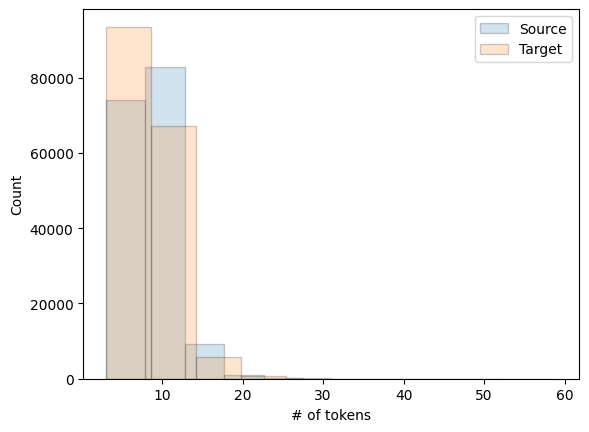

In [ ]:
len_src = [len(x) for x in src]
len_tgt = [len(x) for x in tgt]
plt.hist(len_src, alpha = 0.2, bins = 10, edgecolor = 'black', label = 'Source')
plt.hist(len_tgt, alpha = 0.2, bins = 10, edgecolor = 'black', label = 'Target')
plt.legend()
plt.xlabel('# of tokens')
plt.ylabel('Count')
plt.show()

In [ ]:
data = MTFraEng(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.get_dataloader(train = True)))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

source: tensor([[193, 135,   2,   3,   4,   4,   4,   4,   4],
        [ 39, 122,   2,   3,   4,   4,   4,   4,   4],
        [ 57,  37,   2,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3, 199,  55,   2,   4,   5,   5,   5,   5],
        [  3,   6,   0,   4,   5,   5,   5,   5,   5],
        [  3,   6,   0,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 4, 4], dtype=torch.int32)
label: tensor([[199,  55,   2,   4,   5,   5,   5,   5,   5],
        [  6,   0,   4,   5,   5,   5,   5,   5,   5],
        [  6,   0,   4,   5,   5,   5,   5,   5,   5]], dtype=torch.int32)


In [ ]:
src, tgt, _,  _ = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


# Encoder-Decoder skeleton

## Encoder

In [ ]:
class Encoder(nn.Module):

  def __init__(self):
    super().__init__()

  def forward(self, X, *args):
    raise NotImplementedError

## Decoder

In [ ]:
class Decoder(nn.Module):

  def __init__(self):
    super().__init__()

  def init_state(self, enc_all_outputs, *args):
    raise NotImplementedError

  def forward(self, X, state):
    raise NotImplementedError

## Encoder-Decoder

In [ ]:
class EncoderDecoder(nn.Module):

  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_X, dec_X, *args):
    enc_all_outputs = self.encoder(enc_X, *args)
    dec_state = self.decoder.init_state(enc_all_outputs, *args)
    return self.decoder(dec_X, dec_state)[0]



# Seq2Seq for Machine Translation

## Encoder

In [ ]:
def init_seq2seq(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

In [ ]:
class Seq2SeqEncoder(Encoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout = dropout)
    #self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, bias=True, batch_first=False, dropout=0.0, bidirectional=False)
    self.apply(init_seq2seq)

  def forward(self, X, *args):
    X = X.t().long()
    embs = self.embedding(X)
    outputs, state = self.rnn(embs)
    return outputs, state

In [ ]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
enc_outputs, enc_state = encoder(X)

## Decoder

In [ ]:
class Seq2SeqDecoder(Decoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout = dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)
    self.apply(init_seq2seq)

  def init_state(self, enc_all_outputs, *args):
    return enc_all_outputs

  def forward(self, X, state):
    embs = self.embedding(X.t().long())
    enc_output, hidden_state = state
    context = enc_output[-1]
    context = context.repeat(embs.shape[0], 1, 1)
    embs_and_context = torch.cat((embs, context), -1)
    outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
    outputs = self.dense(outputs).swapaxes(0, 1)
    return outputs, [enc_output, hidden_state]

In [ ]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)

## Encoder-Decoder for Seq2Seq Learning

In [ ]:
def seq2seq_loss(Y_hat, Y, pad_idx):
    """
    Y_hat: (batch, T, vocab)
    Y:     (batch, T)
    """
    vocab_size = Y_hat.shape[-1]

    loss = F.cross_entropy(
        Y_hat.reshape(-1, vocab_size),
        Y.reshape(-1),
        reduction="none"
    )

    mask = (Y.reshape(-1) != pad_idx).float()
    return (loss * mask).sum() / mask.sum()

In [ ]:
class Seq2Seq(EncoderDecoder):
    def __init__(self, encoder, decoder, tgt_pad):
        super().__init__(encoder, decoder)
        self.tgt_pad = tgt_pad

    def loss(self, Y_hat, Y):
        return seq2seq_loss(Y_hat, Y, self.tgt_pad)

In [ ]:
data = MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 30

In [ ]:
pad_idx = data.tgt_vocab['<pad>']

train_loader = data.get_dataloader(train=True)
val_loader = data.get_dataloader(train=False)

train_loss = []
val_loss = []
val_accuracy = []

for epoch in range(n_epochs):

    # ======================
    # Training
    # ======================
    model.train()
    total_loss = 0.0
    total_tokens = 0

    for enc_X, dec_X, _, Y in train_loader:
        enc_X = enc_X.to(device)
        dec_X = dec_X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()

        # forward
        Y_hat = model(enc_X, dec_X)   # (batch, T, vocab)

        loss = model.loss(Y_hat, Y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        num_tokens = (Y != pad_idx).sum().item()
        total_loss += loss.item() * num_tokens
        total_tokens += num_tokens

    train_loss.append(total_loss / total_tokens)

    # ======================
    # Validation
    # ======================
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    total_correct = 0

    with torch.no_grad():
        for enc_X, dec_X, _, Y in val_loader:
            enc_X = enc_X.to(device)
            dec_X = dec_X.to(device)
            Y = Y.to(device)

            Y_hat = model(enc_X, dec_X)

            loss = model.loss(Y_hat, Y)

            preds = Y_hat.argmax(dim=-1)
            mask = (Y != pad_idx)

            total_correct += ((preds == Y) & mask).sum().item()
            total_loss += loss.item() * mask.sum().item()
            total_tokens += mask.sum().item()

    val_loss.append(total_loss / total_tokens)
    val_accuracy.append(total_correct / total_tokens)

    print(
        f"Epoch {epoch+1:02d} | "
        f"train loss {train_loss[-1]:.4f} | "
        f"val loss {val_loss[-1]:.4f} | "
        f"val acc {val_accuracy[-1]:.4f}"
    )

Epoch 01 | train loss 4.4096 | val loss 3.6419 | val acc 0.2484
Epoch 02 | train loss 3.0211 | val loss 3.3811 | val acc 0.2755
Epoch 03 | train loss 2.7118 | val loss 3.0757 | val acc 0.3790
Epoch 04 | train loss 2.4848 | val loss 2.9976 | val acc 0.3933
Epoch 05 | train loss 2.3419 | val loss 2.9482 | val acc 0.4506
Epoch 06 | train loss 2.2281 | val loss 2.8938 | val acc 0.4554
Epoch 07 | train loss 2.1171 | val loss 2.8461 | val acc 0.5127
Epoch 08 | train loss 2.0167 | val loss 2.8140 | val acc 0.5159
Epoch 09 | train loss 1.9059 | val loss 2.7454 | val acc 0.5271
Epoch 10 | train loss 1.8055 | val loss 2.7157 | val acc 0.5334
Epoch 11 | train loss 1.7032 | val loss 2.6946 | val acc 0.5366
Epoch 12 | train loss 1.5897 | val loss 2.6717 | val acc 0.5398
Epoch 13 | train loss 1.4989 | val loss 2.6930 | val acc 0.5366
Epoch 14 | train loss 1.4031 | val loss 2.6495 | val acc 0.5382
Epoch 15 | train loss 1.3071 | val loss 2.7012 | val acc 0.5446
Epoch 16 | train loss 1.2228 | val loss 

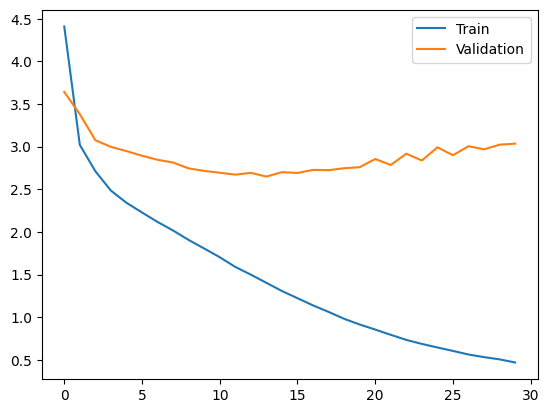

In [ ]:
plt.plot(train_loss, label = 'Train')
plt.plot(val_loss, label = 'Validation')
plt.legend()
plt.show()